In [1]:
"""
Created on August 4th 2022

@author: JJ
"""

'\nCreated on August 4th 2022\n\n@author: JJ\n'

In [2]:
import os, re, sys
import numpy as np
import pandas as pd
from math import log
import random
import scipy.io
import tensorflow as tf
import csv

2022-08-23 17:28:19.411152: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
num_threads = 4
# Maximum number of threads to use for OpenMP parallel regions.
os.environ["OMP_NUM_THREADS"] = "4"
# Without setting below 2 environment variables, it didn't work for me. Thanks to @cjw85 
os.environ["TF_NUM_INTRAOP_THREADS"] = "4"
os.environ["TF_NUM_INTEROP_THREADS"] = "4"

tf.config.threading.set_inter_op_parallelism_threads(
    num_threads
)
tf.config.threading.set_intra_op_parallelism_threads(
    num_threads
)
tf.config.set_soft_device_placement(True)

In [4]:
# in a well-defined initial state.
random.seed
np.random.seed(1337)
tf.random.set_seed(1337)

In [5]:
import matplotlib
import matplotlib.pyplot as plt

In [6]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import (
    ModelCheckpoint, 
    EarlyStopping
)
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)
from tensorflow.keras.regularizers import (
    l2, 
    l1, 
    l1_l2
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import (
    activations, 
    initializers, 
    regularizers, 
    constraints
)

In [7]:
class Attention(Layer):
    def __init__(
        self,
        hidden,
        init="glorot_uniform",
        activation="linear",
        W_regularizer=None,
        b_regularizer=None,
        W_constraint=None,
        **kwargs
    ):
        self.init = initializers.get(init)
        self.activation = activations.get(activation)
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.hidden = hidden
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.input_length = input_shape[1]
        self.W0 = self.add_weight(
            name="{}_W1".format(self.name),
            shape=(input_dim, self.hidden),
            initializer="glorot_uniform",
            trainable=True,
        )  # Keras 2 API
        self.W = self.add_weight(
            name="{}_W".format(self.name),
            shape=(self.hidden, 1),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b0 = K.zeros((self.hidden,), name="{}_b0".format(self.name))
        self.b = K.zeros((1,), name="{}_b".format(self.name))
        # AttributeError: Can't set the attribute "trainable_weights",
        # likely because it conflicts with an existing read-only @property of the object.
        # Please choose a different name.
        # https://issueexplorer.com/issue/wenguanwang/ASNet/8
        self._trainable_weights = [self.W0, self.W, self.b, self.b0]

        self.regularizers = []
        if self.W_regularizer:
            self.W_regularizer.set_param(self.W)
            self.regularizers.append(self.W_regularizer)

        if self.b_regularizer:
            self.b_regularizer.set_param(self.b)
            self.regularizers.append(self.b_regularizer)

        self.constraints = {}
        if self.W_constraint:
            self.constraints[self.W0] = self.W_constraint
            self.constraints[self.W] = self.W_constraint

        super(Attention, self).build(input_shape)

    def call(self, x, mask=None):
        attmap = self.activation(K.dot(x, self.W0) + self.b0)
        attmap = K.dot(attmap, self.W) + self.b
        attmap = K.reshape(
            attmap, (-1, self.input_length)
        )  # Softmax needs one dimension
        attmap = K.softmax(attmap)
        dense_representation = K.batch_dot(attmap, x, axes=(1, 1))
        out = K.concatenate(
            [dense_representation, attmap]
        )  # Output the attention maps but do not pass it to the next layer by DIY flatten layer
        return out

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1] + input_shape[1])

    def get_config(self):
        config = {
            "init": "glorot_uniform",
            "activation": self.activation.__name__,
            "W_constraint": self.W_constraint.get_config()
            if self.W_constraint
            else None,
            "W_regularizer": self.W_regularizer.get_config()
            if self.W_regularizer
            else None,
            "b_regularizer": self.b_regularizer.get_config()
            if self.b_regularizer
            else None,
            "hidden": self.hidden if self.hidden else None,
        }
        base_config = super(Attention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class attention_flatten(Layer):  # Based on the source code of Keras flatten
    def __init__(self, keep_dim, **kwargs):
        self.keep_dim = keep_dim # 64
        super(attention_flatten, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        if not all(input_shape[1:]):
            raise Exception(
                'The shape of the input to "Flatten" '
                "is not fully defined "
                "(got " + str(input_shape[2:]) + ". "
                'Make sure to pass a complete "input_shape" '
                'or "batch_input_shape" argument to the first '
                "layer in your model."
            )
        return (input_shape[0], self.keep_dim)  # Remove the attention map

    def call(self, x, mask=None):
        x = x[:, : self.keep_dim]
        #return K.batch_flatten(x)
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        return config

In [8]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import resample, shuffle
from sklearn.feature_selection import (
    SelectKBest,
    chi2
)
import keras_tuner as kt
from collections import defaultdict

In [10]:
#import pickle
#with open ('fulldata_pseudoseq_dictionary.pkl', 'rb') as f:
#    pseudo_seq = pickle.load(f)

In [9]:
import pickle
with open ('fulldata_pseudoseq_dictionary_converted.pkl', 'rb') as f:
    pseudo_seq = pickle.load(f)

In [10]:
type(pseudo_seq)

dict

In [11]:
    training_data = []
    for allele in pseudo_seq.keys():
        allele_data = pseudo_seq[allele]
        random.shuffle(allele_data)
        allele_data = np.array(allele_data)
        training_data.extend(allele_data)
    
    [all_pep, all_mhc, all_target] = [[i[j] for i in training_data] for j in range(3)]
    all_pep = np.array(all_pep)
    all_mhc = np.array(all_mhc)
    all_target = np.array(all_target)

/tmp/ipykernel_81602/3434162491.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allele_data = np.array(allele_data)


In [12]:
#read these scripts
#https://github.com/HYsxe/ACME/tree/master/ACME_codes
#https://github.com/HYsxe/ACME/blob/master/ACME_codes/read_binding_data.py
#https://github.com/HYsxe/ACME/blob/master/ACME_codes/pseudo_seq.py
#https://github.com/HYsxe/ACME/blob/master/ACME_codes/allele_list.py
#https://github.com/HYsxe/ACME/blob/master/ACME_codes/allele_seq.py
#https://github.com/HYsxe/ACME/blob/master/ACME_codes/model_training.py


In [13]:
print(all_pep.shape)
print(all_mhc.shape)
print(all_target.shape)

(945434, 30, 20)
(945434, 34, 20)
(945434,)


In [21]:
print(all_mhc[0])

YSAMYEEKVAHTDENIAYLMFHYYTWAVQAYTGY


In [14]:
print(all_mhc[0])

[[-0.2 -0.1 -0.2 -0.3 -0.3 -0.1 -0.2 -0.3  0.2 -0.1 -0.1 -0.2  0.   0.4
  -0.3 -0.2 -0.2  0.2  0.8 -0.1]
 [ 0.1 -0.1  0.1  0.  -0.1  0.  -0.1  0.  -0.1 -0.3 -0.3  0.  -0.2 -0.3
  -0.1  0.5  0.2 -0.4 -0.2 -0.2]
 [ 0.5 -0.2 -0.1 -0.2 -0.1 -0.1 -0.1  0.  -0.2 -0.1 -0.2 -0.1 -0.1 -0.3
  -0.1  0.1  0.  -0.3 -0.2  0. ]
 [-0.1 -0.2 -0.2 -0.4 -0.2  0.  -0.2 -0.3 -0.1  0.2  0.3 -0.2  0.7  0.
  -0.3 -0.2 -0.1 -0.1  0.   0.1]
 [-0.2 -0.1 -0.2 -0.3 -0.3 -0.1 -0.2 -0.3  0.2 -0.1 -0.1 -0.2  0.   0.4
  -0.3 -0.2 -0.2  0.2  0.8 -0.1]
 [-0.1  0.   0.   0.2 -0.3  0.2  0.6 -0.3  0.  -0.4 -0.3  0.1 -0.2 -0.3
  -0.1 -0.1 -0.1 -0.3 -0.2 -0.3]
 [-0.1  0.   0.   0.2 -0.3  0.2  0.6 -0.3  0.  -0.4 -0.3  0.1 -0.2 -0.3
  -0.1 -0.1 -0.1 -0.3 -0.2 -0.3]
 [-0.1  0.3  0.  -0.1 -0.3  0.2  0.1 -0.2  0.  -0.3 -0.3  0.6 -0.2 -0.4
  -0.1  0.  -0.1 -0.3 -0.2 -0.3]
 [ 0.  -0.3 -0.3 -0.4 -0.1 -0.3 -0.3 -0.4 -0.4  0.4  0.1 -0.3  0.1 -0.1
  -0.3 -0.2  0.  -0.3 -0.1  0.5]
 [ 0.5 -0.2 -0.1 -0.2 -0.1 -0.1 -0.1  0.  -0.2 -0.1 -0.2

In [15]:
#np.save('/home/jjia1/jjia1/viralepitope/all_pep.npy', all_pep)
#np.save('/home/jjia1/jjia1/viralepitope/all_mhc.npy', all_mhc)
#np.save('/home/jjia1/jjia1/viralepitope/all_target.npy', all_target)

In [15]:
np.save('/home/jjia1/jjia1/viralepitope/all_pep_converted.npy', all_pep)
np.save('/home/jjia1/jjia1/viralepitope/all_mhc_converted.npy', all_mhc)
np.save('/home/jjia1/jjia1/viralepitope/all_target_converted.npy', all_target)

In [110]:
#all_pep, all_mhc, all_target = np.load('/home/jjia1/jjia1/viralepitope/all_pep.npy'), np.load('/home/jjia1/jjia1/viralepitope/all_mhc.npy'), np.load('/home/jjia1/jjia1/viralepitope/all_target.npy')

In [ ]:
#all_pep, all_mhc, all_target = np.load('/home/jjia1/jjia1/viralepitope/all_pep_converted.npy'), np.load('/home/jjia1/jjia1/viralepitope/all_mhc_converted.npy'), np.load('/home/jjia1/jjia1/viralepitope/all_target_converted.npy')

In [16]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)    
allprobas_=np.array([]) 
all_labels=np.array([])

In [66]:
#build 2 models
#one model for the sequence, one model for the MHC names
#integrate the outputs in a final dense layer

In [27]:
def build_model(training_pep, training_mhc):
    filters, kernel = 128, 3
    input_pep = Input(shape=(np.shape(training_pep[0])), name = 'peptide')

    conv_pep = Conv1D(filters = filters, kernel_size = kernel, activation = 'relu', 
                        padding = 'same',name = 'conv1_pep')

    conv_pool_out_pep = MaxPooling1D()
    conv_pool_dropout1_pep = Dropout(0.6)
    conv_pool_dropout2_pep = Dropout(0.5)

    decoder_pep = Attention(hidden=256, activation = 'linear')
    dense1_pep = Dense(1)
    
    output1_pep = conv_pep(input_pep)
    output2_pep = conv_pool_out_pep(output1_pep)
    output3_pep = conv_pool_dropout1_pep(output2_pep)

    att_decoder_pep = decoder_pep(output3_pep)
    output4_pep = attention_flatten(output3_pep.shape[2])(att_decoder_pep)
    
    output5_pep = dense1_pep(conv_pool_dropout2_pep(Flatten()(output3_pep)))
    output_all_pep = concatenate([output4_pep, output5_pep])
    output6_pep = Dense(1)(output_all_pep)

    #output_final_pep = Activation('sigmoid')(output6_pep)

    input_mhc = Input(shape=(np.shape(training_mhc[0])), name = 'mhc')

    conv_mhc = Conv1D(filters = filters, kernel_size = kernel, activation = 'relu', 
                        padding = 'same',kernel_constraint = MaxNorm(3), 
                        name = 'conv1_mhc')

    conv_pool_out_mhc = MaxPooling1D()
    conv_pool_dropout1_mhc = Dropout(0.6)
    conv_pool_dropout2_mhc = Dropout(0.5)

    decoder_mhc = Attention(hidden=256, activation = 'linear')
    dense1_mhc = Dense(1)
    
    output1_mhc = conv_mhc(input_mhc)
    output2_mhc = conv_pool_out_mhc(output1_mhc)
    output3_mhc = conv_pool_dropout1_mhc(output2_mhc)

    att_decoder_mhc = decoder_mhc(output3_mhc)
    output4_mhc = attention_flatten(output3_mhc.shape[2])(att_decoder_mhc)
    
    output5_mhc = dense1_mhc(conv_pool_dropout2_mhc(Flatten()(output3_mhc)))
    output_all_mhc = concatenate([output4_mhc, output5_mhc])
    output6_mhc = Dense(1)(output_all_mhc)

    #output_final_mhc = Activation('sigmoid')(output6_mhc)

    combinedOutput = concatenate([output6_pep, output6_mhc])
    combinedDenseOutput = Dense(1)(combinedOutput)
    finalCombinedOutput = Activation('sigmoid')(combinedDenseOutput)

    model = Model(inputs = ([input_pep, input_mhc]), outputs = finalCombinedOutput)
    opt = Adam(learning_rate = 1e-3)
    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy', 'AUC'])
    model.summary()
    return model

In [94]:
def create_model(training_pep, training_mhc):
        filters, kernel_size, fc1_size, fc2_size, fc3_size = 128, 3, 256, 64, 2
        inputs_1 = Input(shape = (np.shape(training_pep[0])[0],20))
        inputs_2 = Input(shape = (34,np.shape(training_mhc[0])[0]))
        #Initial feature extraction using a convolutional layer
        pep_conv = Conv1D(filters,kernel_size,padding = 'same',activation = 'relu',strides = 1)(inputs_1)
        pep_maxpool = MaxPooling1D()(pep_conv)
        mhc_conv_1 = Conv1D(filters,kernel_size,padding = 'same',activation = 'relu',strides = 1)(inputs_2)
        mhc_maxpool_1 = MaxPooling1D()(mhc_conv_1)
        #The convolutional module
        mhc_conv_2 = Conv1D(filters,kernel_size,padding = 'same',activation = 'relu',strides = 1)(mhc_maxpool_1)
        mhc_maxpool_2 = MaxPooling1D()(mhc_conv_2)
        flat_pep_0 = Flatten()(pep_conv)
        flat_pep_1 = Flatten()(pep_conv)
        flat_pep_2 = Flatten()(pep_conv)
        flat_mhc_0 = Flatten()(inputs_2)
        flat_mhc_1 = Flatten()(mhc_maxpool_1)
        flat_mhc_2 = Flatten()(mhc_maxpool_2)
        cat_0 = Concatenate()([flat_pep_0, flat_mhc_0])
        cat_1 = Concatenate()([flat_pep_1, flat_mhc_1])
        cat_2 = Concatenate()([flat_pep_2, flat_mhc_2])        
        fc1_0 = Dense(fc1_size,activation = "relu")(cat_0)
        fc1_1 = Dense(fc1_size,activation = "relu")(cat_1)
        fc1_2 = Dense(fc1_size,activation = "relu")(cat_2)
        merge_1 = Concatenate()([fc1_0, fc1_1, fc1_2])
        fc2 = Dense(fc2_size,activation = "relu")(merge_1)
        fc3 = Dense(fc3_size,activation = "relu")(fc2)
        #The attention module
        mhc_attention_weights = Flatten()(TimeDistributed(Dense(1))(mhc_conv_1))
        pep_attention_weights = Flatten()(TimeDistributed(Dense(1))(pep_conv))
        mhc_attention_weights = Activation('softmax')(mhc_attention_weights)
        pep_attention_weights = Activation('softmax')(pep_attention_weights)        
        mhc_conv_permute = Permute((2,1))(mhc_conv_1)
        pep_conv_permute = Permute((2,1))(pep_conv)
        mhc_attention = Dot(-1)([mhc_conv_permute, mhc_attention_weights])
        pep_attention = Dot(-1)([pep_conv_permute, pep_attention_weights])
        #Concatenating the output of the two modules
        merge_2 = Concatenate()([mhc_attention,pep_attention,fc3])
        #Output of the model
        out = Dense(1,activation = "sigmoid")(merge_2)
        model = Model(inputs=[inputs_1, inputs_2],outputs=out)  
        model.summary()
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

In [18]:
es = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 5)

In [39]:
train_pep, test_pep, train_mhc, test_mhc, train_target, test_target = train_test_split(all_pep, all_mhc, all_target, test_size = 0.2, stratify= all_target)

In [40]:
print(train_pep.shape)
print(test_pep.shape)

(756347, 30, 20)
(189087, 30, 20)


In [41]:
for i, (train, test) in enumerate(kfold.split(train_pep, train_target)):
    training_pep = train_pep[train]
    training_mhc = train_mhc[train]
    training_target = train_target[train]
    
    validation_pep = train_pep[test]
    validation_mhc = train_mhc[test]
    validation_target = train_target[test]

In [42]:
del model
model = build_model(training_pep, training_mhc)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
peptide (InputLayer)            [(None, 30, 20)]     0                                            
__________________________________________________________________________________________________
mhc (InputLayer)                [(None, 34, 20)]     0                                            
__________________________________________________________________________________________________
conv1_pep (Conv1D)              (None, 30, 128)      7808        peptide[0][0]                    
__________________________________________________________________________________________________
conv1_mhc (Conv1D)              (None, 34, 128)      7808        mhc[0][0]                        
____________________________________________________________________________________________

In [44]:
saved_model = model.fit([training_pep,training_mhc], 
            training_target,
            batch_size=512,
            epochs = 100,
            shuffle=True,
            callbacks=[es],
            validation_data=([validation_pep,validation_mhc], validation_target),
            verbose=1)

Epoch 1/100
1182/1182 [==============================] - 95s 80ms/step - loss: 0.2695 - accuracy: 0.9094 - auc: 0.7570 - val_loss: 0.2149 - val_accuracy: 0.9135 - val_auc: 0.8812
Epoch 2/100
1182/1182 [==============================] - 90s 77ms/step - loss: 0.2165 - accuracy: 0.9135 - auc: 0.8752 - val_loss: 0.2062 - val_accuracy: 0.9162 - val_auc: 0.8928
Epoch 3/100
1182/1182 [==============================] - 89s 75ms/step - loss: 0.2103 - accuracy: 0.9151 - auc: 0.8836 - val_loss: 0.2024 - val_accuracy: 0.9169 - val_auc: 0.8964
Epoch 4/100
1182/1182 [==============================] - 88s 75ms/step - loss: 0.2078 - accuracy: 0.9159 - auc: 0.8874 - val_loss: 0.2008 - val_accuracy: 0.9174 - val_auc: 0.8981
Epoch 5/100
1182/1182 [==============================] - 88s 75ms/step - loss: 0.2084 - accuracy: 0.9152 - auc: 0.8882 - val_loss: 0.2006 - val_accuracy: 0.9169 - val_auc: 0.8990
Epoch 6/100
1182/1182 [==============================] - 89s 75ms/step - loss: 0.2056 - accuracy: 0.9167 

In [45]:
probas_ = saved_model.model.predict([np.array(validation_pep),np.array(validation_mhc)])
allprobas_ = np.append(allprobas_, probas_)           
all_labels = np.append(all_labels, validation_target)

0.9068510812113243


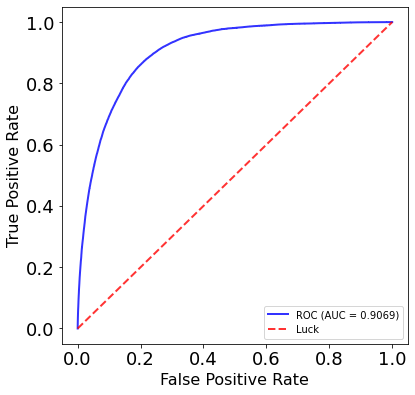

In [46]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

########ROC_figure
figure1, ax1 = plt.subplots(figsize=figsize)
ax1.tick_params(labelsize=18)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]  

fpr, tpr, thresholds = roc_curve(all_labels, allprobas_)
roc_auc = auc(fpr, tpr)
print(roc_auc)

ax1.plot(fpr, tpr, color='b',
    label=r'ROC (AUC = %0.4f)' % (roc_auc),
    lw=2, alpha=.8)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate', font1)
ax1.set_ylabel('True Positive Rate', font1)
# title1 = 'Cross Validated ROC Curve'
# ax1.set_title(title1, font1)
ax1.legend(loc="lower right")

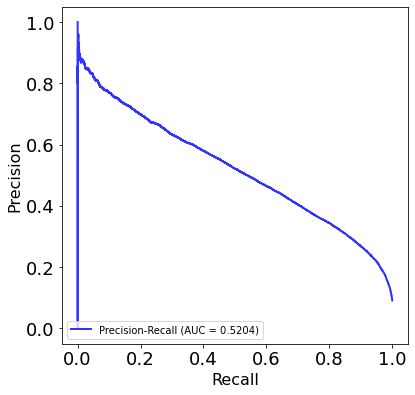

In [47]:
########PR_figure
figure2, ax2 = plt.subplots(figsize=figsize)
ax2.tick_params(labelsize=18)
labels = ax2.get_xticklabels() + ax2.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels] 

precision, recall, _ = precision_recall_curve(all_labels, allprobas_)
ax2.plot(recall, precision, color='b',
        label=r'Precision-Recall (AUC = %0.4f)' % (average_precision_score(all_labels, allprobas_)),
        lw=2, alpha=.8)

ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('Recall', font1)
ax2.set_ylabel('Precision', font1)
# title2 = 'Cross Validated PR Curve'
# ax2.set_title(title2, font1)
ax2.legend(loc="lower left")

In [48]:
probas_ = saved_model.model.predict([np.array(test_pep),np.array(test_mhc)])
allprobas_ = np.append(allprobas_, probas_)           
all_labels = np.append(all_labels, validation_target)

0.9091132313399066


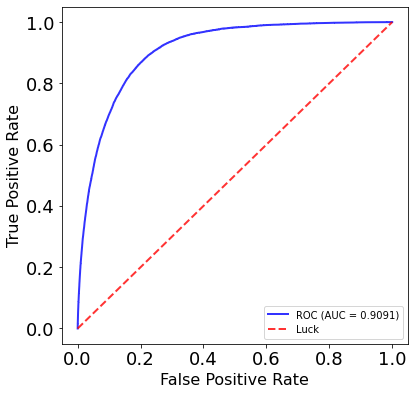

In [51]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

########ROC_figure
figure1, ax1 = plt.subplots(figsize=figsize)
ax1.tick_params(labelsize=18)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]  

fpr, tpr, thresholds = roc_curve(test_target, probas_)
roc_auc = auc(fpr, tpr)
print(roc_auc)

ax1.plot(fpr, tpr, color='b',
    label=r'ROC (AUC = %0.4f)' % (roc_auc),
    lw=2, alpha=.8)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate', font1)
ax1.set_ylabel('True Positive Rate', font1)
# title1 = 'Cross Validated ROC Curve'
# ax1.set_title(title1, font1)
ax1.legend(loc="lower right")

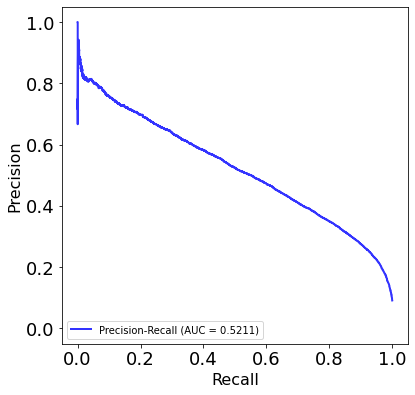

In [54]:
########PR_figure
figure2, ax2 = plt.subplots(figsize=figsize)
ax2.tick_params(labelsize=18)
labels = ax2.get_xticklabels() + ax2.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels] 

precision, recall, _ = precision_recall_curve(test_target, probas_)
ax2.plot(recall, precision, color='b',
        label=r'Precision-Recall (AUC = %0.4f)' % (average_precision_score(test_target, probas_)),
        lw=2, alpha=.8)

ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('Recall', font1)
ax2.set_ylabel('Precision', font1)
# title2 = 'Cross Validated PR Curve'
# ax2.set_title(title2, font1)
ax2.legend(loc="lower left")

In [55]:
print(saved_model.history.keys())

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


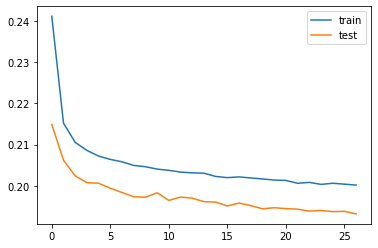

In [58]:
plt.plot(saved_model.history["loss"])
plt.plot(saved_model.history["val_loss"])
plt.legend(['train', 'test'], loc='best')

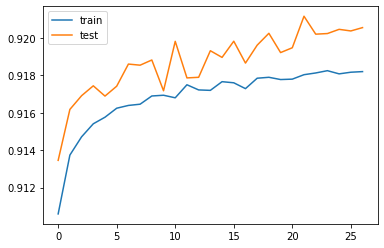

In [59]:
plt.plot(saved_model.history["accuracy"])
plt.plot(saved_model.history["val_accuracy"])
plt.legend(['train', 'test'], loc='best')